In [2]:
import torch
import torch.backends.cudnn as cudnn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import torch
from drawinganalyses.datasets.drawing_collection import DrawingCollection

cudnn.benchmark = True
plt.ion()   # interactive mode

In [3]:
LOCAL_DATA_DIR = Path("/home/emaitre/MADE/molly-humains/")

In [4]:
label_to_str = {0: 'Autumn', 1: 'Spring', 2: 'Summer', 3: 'Winter'}

In [5]:
drawing_collection = DrawingCollection(LOCAL_DATA_DIR / 'Molly')
images = drawing_collection.get_images()
labels = drawing_collection.get_labels()

1300it [04:29,  4.82it/s]


In [8]:
images = np.array(images)

In [20]:
map_chan = {0:'r', 1:'g', 2:'b'}
chan = {}
for i in range(images.shape[-1]):
    chan[map_chan[i]] = images[:,:,:,i]

for channel, values in chan.items():
    print('channel :', channel)
    print('mean :', np.mean(values))
    print('std :', np.std(values))
    print('max :', values.max())
    print('min :', values.min())


In [12]:
X_train, X_test = np.array(images[0:1000]), np.array(images[1000:])
Y_train, Y_test = np.array(labels[0:1000]), np.array(labels[1000:])

In [25]:
from drawinganalyses.utils.utils import feature_extraction

/home/emaitre/miniconda3/envs/MADE/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [26]:
# Extracting train features

import numpy as np
total = np.empty((len(X_train), 3, 44))
for idx, image in enumerate(X_train):
    feat, labels_feat = feature_extraction(image)
    total[idx] = feat

In [27]:
features_train = total.reshape(total.shape[0], -1)

In [28]:
import xgboost as xgb

In [29]:
# Renaming features to ensure we can differentiate between channels

chans = ['r', 'g', 'b']
labels_name = []
for chan in chans:
    for idx, label_feat in enumerate(labels_feat):
        labels_name.append(f"{chan}_{label_feat}")

In [30]:
model = xgb.XGBClassifier()
model.fit(features_train, Y_train)
model.get_booster().feature_names = labels_name

In [52]:
# Extracting test features

total_test = np.empty((len(X_test), 3, 44))
for idx, image in enumerate(X_test):
    feat, labels_feat = feature_extraction(image)
    total_test[idx] = feat

In [50]:
feature_test =  total_test.reshape(total_test.shape[0], -1)

(299, 132)

In [ ]:
prediction = model.predict(feature_test)

In [33]:
from sklearn import metrics

In [34]:
print('Accuracy = ', metrics.accuracy_score(Y_test, prediction))

Accuracy =  0.29431438127090304


In [35]:
from sklearn.metrics import confusion_matrix

In [36]:
def convert_array_with_mapping(arr, mapping_dict):
    # Utilisez la fonction vectorisée np.vectorize pour appliquer la conversion à chaque élément du tableau
    convert_func = np.vectorize(lambda x: mapping_dict.get(x, str(x)))
    converted_arr = convert_func(arr)
    return converted_arr

In [37]:
result_array = convert_array_with_mapping(prediction, label_to_str)
label_test = convert_array_with_mapping(Y_test, label_to_str)

In [38]:
cm = confusion_matrix(label_test, result_array)

<Axes: >

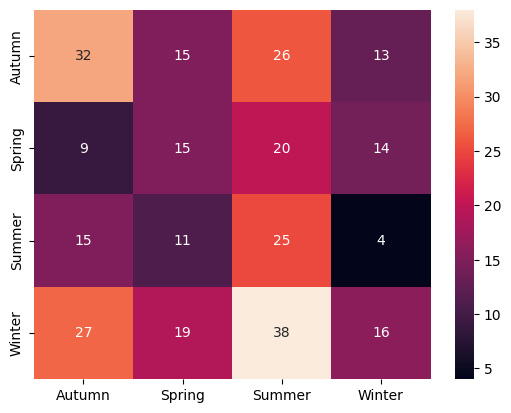

In [39]:
import seaborn as sns

sns.heatmap(cm, annot=True, xticklabels=label_to_str.values(), yticklabels= label_to_str.values())

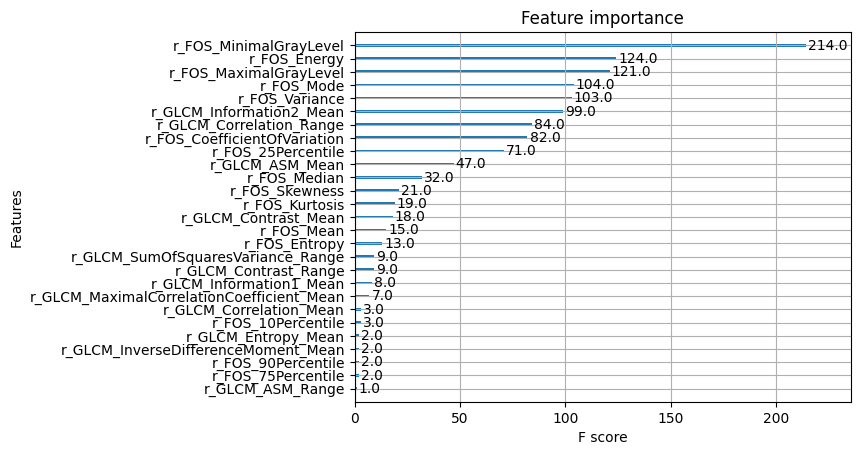

In [40]:
# plot feature importance

from xgboost import plot_importance
from matplotlib import pyplot

plot_importance(model)
pyplot.show()

In [49]:
model.get_booster().get_score()

{'r_FOS_Mean': 15.0,
 'r_FOS_Variance': 103.0,
 'r_FOS_Median': 32.0,
 'r_FOS_Mode': 104.0,
 'r_FOS_Skewness': 21.0,
 'r_FOS_Kurtosis': 19.0,
 'r_FOS_Energy': 124.0,
 'r_FOS_Entropy': 13.0,
 'r_FOS_MinimalGrayLevel': 214.0,
 'r_FOS_MaximalGrayLevel': 121.0,
 'r_FOS_CoefficientOfVariation': 82.0,
 'r_FOS_10Percentile': 3.0,
 'r_FOS_25Percentile': 71.0,
 'r_FOS_75Percentile': 2.0,
 'r_FOS_90Percentile': 2.0,
 'r_GLCM_ASM_Mean': 47.0,
 'r_GLCM_Contrast_Mean': 18.0,
 'r_GLCM_Correlation_Mean': 3.0,
 'r_GLCM_InverseDifferenceMoment_Mean': 2.0,
 'r_GLCM_Entropy_Mean': 2.0,
 'r_GLCM_Information1_Mean': 8.0,
 'r_GLCM_Information2_Mean': 99.0,
 'r_GLCM_MaximalCorrelationCoefficient_Mean': 7.0,
 'r_GLCM_ASM_Range': 1.0,
 'r_GLCM_Contrast_Range': 9.0,
 'r_GLCM_Correlation_Range': 84.0,
 'r_GLCM_SumOfSquaresVariance_Range': 9.0}